<center>
    <h1>QF5214 - Final Project</h1>
    <h2>Written by: SHUAI Yifan/Zhou Wanyue/Jin Zixiang/Bi Haoyu/Zilin/Jiamin</h2>
    <h3>Student ID: A0274472Y/...</h3>
    <h4>Date: 29/03/2024</h4>
</center>

<center>
<h2> Topic: Walmart Store Future Sales Forecast </h2>
</center>

## 1. Data Visualization

### 1.1 Basic Data Information

In [1]:
#pip install lightgbm

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import datetime as dt
import lightgbm as lgb

#visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Time series analysis
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

# Data preprocessing
from sklearn.model_selection import train_test_split

# Grid search
from sklearn.model_selection import GridSearchCV

# Validataion
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.display import Image

In [3]:
# Load Dataset
cal = pd.read_csv('calendar.csv') #calendar data
sales_train = pd.read_csv('sales_train_validation.csv') #sales_train data
sell_price = pd.read_csv('sell_prices.csv') #sell_price data
sample = pd.read_csv('sample_submission.csv')

In [4]:
# see how data look like
sample.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
sell_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


#### 1.1.1 Data Shape

In [8]:
# See the shape of data

print("Train data: {}".format(sales_train.shape))
print("Calender data: {}".format(cal.shape))
print("Sell Price data: {}".format(sell_price.shape))
print("Sample data: {}".format(sample.shape))

Train data: (30490, 1919)

Calender data: (1969, 14)

Sell Price data: (6841121, 4)

Sample data: (60980, 29)


#### 1.1.2 Data Entity Relationship

In [9]:
#from IPython.display import Image
#Image("./Walmart_dataEntity.jpg")

### 1.2 Exploratory Data Analysis & Feature Engneering

In [10]:
# change the data type of date in calendar data

cal['Date_dt']=pd.to_datetime(cal['date'])

In [11]:
# create sql db file
fn = './Walmart_data.db'
conn = sqlite3.connect(fn)
cur = conn.cursor()

In [12]:
# store sell_price and calendar data into the database
# train data consists of two many columns, so in this project we'll directly use python to deal with it
r = cur.execute('''DROP TABLE IF EXISTS sell_price''')
r = cur.execute('''DROP TABLE IF EXISTS cal''')
conn.commit()

# insert into sql
sell_price.to_sql(name='sell_price', con=conn,if_exists='append',index=False)
cal.to_sql(name='cal', con=conn,if_exists='append',index=False)

In [13]:
#data copy

train = sales_train.copy()
calendar = cal.copy()
price = sell_price.copy()

#### 1.2.1 Calender Dataset Analysis

In [14]:
cur.execute("select year,count(event_name_1),count(event_type_1),count(event_name_2),count(event_type_2) from cal group by year")
# pd.Series(cur.description).map(lambda x:x[0])
cur.fetchall()

[(2011, 26, 26, 1, 1),
 (2012, 30, 30, 0, 0),
 (2013, 29, 29, 1, 1),
 (2014, 28, 28, 2, 2),
 (2015, 30, 30, 0, 0),
 (2016, 19, 19, 1, 1)]

In [15]:
# check calender data

# Number of events per year
cur.execute("select year,count(event_name_1),count(event_type_1),count(event_name_2),count(event_type_2) from cal group by year")
cur.fetchall()

[(2011, 26, 26, 1, 1),
 (2012, 30, 30, 0, 0),
 (2013, 29, 29, 1, 1),
 (2014, 28, 28, 2, 2),
 (2015, 30, 30, 0, 0),
 (2016, 19, 19, 1, 1)]

In [16]:
# Number of flags per year by store
cur.execute("select year,sum(snap_CA),sum(snap_TX),sum(snap_WI) from cal group by year")
cur.fetchall()

[(2011, 110, 110, 110),
 (2012, 120, 120, 120),
 (2013, 120, 120, 120),
 (2014, 120, 120, 120),
 (2015, 120, 120, 120),
 (2016, 60, 60, 60)]

#### 1.2.2 Sell Prices Dataset Analysis

In [17]:
# Show up the number of stores and store_id relatively
cur.execute("select count(store_id) from (select DISTINCT store_id from sell_price) union select DISTINCT store_id from sell_price")
cur.fetchall()

[(10,),
 ('CA_1',),
 ('CA_2',),
 ('CA_3',),
 ('CA_4',),
 ('TX_1',),
 ('TX_2',),
 ('TX_3',),
 ('WI_1',),
 ('WI_2',),
 ('WI_3',)]

In [18]:
# number of items
cur.execute("select count(item_id) from (select DISTINCT item_id from sell_price) union select DISTINCT item_id from sell_price")
cur.fetchall()

[(3049,),
 ('FOODS_1_001',),
 ('FOODS_1_002',),
 ('FOODS_1_003',),
 ('FOODS_1_004',),
 ('FOODS_1_005',),
 ('FOODS_1_006',),
 ('FOODS_1_008',),
 ('FOODS_1_009',),
 ('FOODS_1_010',),
 ('FOODS_1_011',),
 ('FOODS_1_012',),
 ('FOODS_1_013',),
 ('FOODS_1_014',),
 ('FOODS_1_015',),
 ('FOODS_1_016',),
 ('FOODS_1_017',),
 ('FOODS_1_018',),
 ('FOODS_1_019',),
 ('FOODS_1_020',),
 ('FOODS_1_021',),
 ('FOODS_1_022',),
 ('FOODS_1_023',),
 ('FOODS_1_024',),
 ('FOODS_1_025',),
 ('FOODS_1_026',),
 ('FOODS_1_027',),
 ('FOODS_1_028',),
 ('FOODS_1_029',),
 ('FOODS_1_030',),
 ('FOODS_1_031',),
 ('FOODS_1_032',),
 ('FOODS_1_033',),
 ('FOODS_1_034',),
 ('FOODS_1_035',),
 ('FOODS_1_036',),
 ('FOODS_1_037',),
 ('FOODS_1_038',),
 ('FOODS_1_039',),
 ('FOODS_1_040',),
 ('FOODS_1_041',),
 ('FOODS_1_042',),
 ('FOODS_1_043',),
 ('FOODS_1_044',),
 ('FOODS_1_045',),
 ('FOODS_1_046',),
 ('FOODS_1_047',),
 ('FOODS_1_048',),
 ('FOODS_1_049',),
 ('FOODS_1_050',),
 ('FOODS_1_051',),
 ('FOODS_1_052',),
 ('FOODS_1_053',),
 (

- Average of Sell Prices

In [19]:
# Entire average of sell prices

cur.execute("select avg(sell_price) from sell_price")
cur.fetchall()

[(4.41095238924595,)]

- Standard Deviation of Sell Prices

In [20]:
print("Standard Deviation of Selff Prices - Walmart: {}".format(price["sell_price"].std()))

Standard Deviation of Selff Prices - Walmart: 3.408813704711434


In [21]:
!pip show seaborn

Name: seaborn

Version: 0.11.2

Summary: seaborn: statistical data visualization

Home-page: https://seaborn.pydata.org

Author: Michael Waskom

Author-email: mwaskom@gmail.com

License: BSD (3-clause)

Location: c:\users\zhouw\anaconda3\lib\site-packages

Requires: matplotlib, pandas, scipy, numpy

Required-by: 


- Price Data Distribution

C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


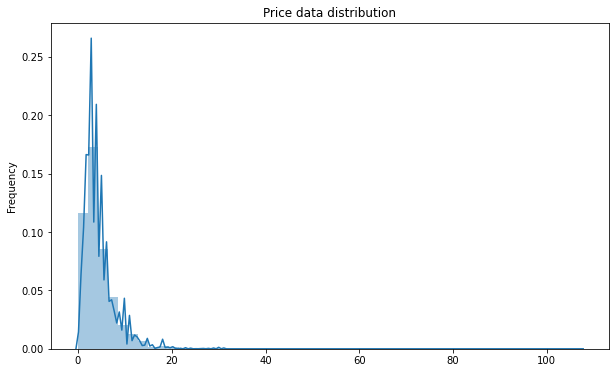

In [22]:
# check the distribution of prices

cur.execute("select sell_price from sell_price")
plt.figure(figsize=(10,6))
sns.distplot(cur.fetchall())
plt.title("Price data distribution")
plt.ylabel("Frequency");

In [23]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

- Distribution of Sales Between different Stores

In [24]:
# plt.style.use('seaborn-v0_8-darkgrid')  # Setting the style for the plots

# # Categorical Feature Distribution: 'store_id'
# plt.figure(figsize=(10, 6))
# sns.countplot(data=price, x='store_id')
# plt.title('Distribution of Sales Across Stores')
# plt.xlabel('Store ID')
# plt.ylabel('Number of Sales')
# plt.xticks(rotation=45)
# plt.show()

- Average Selling price over time by year

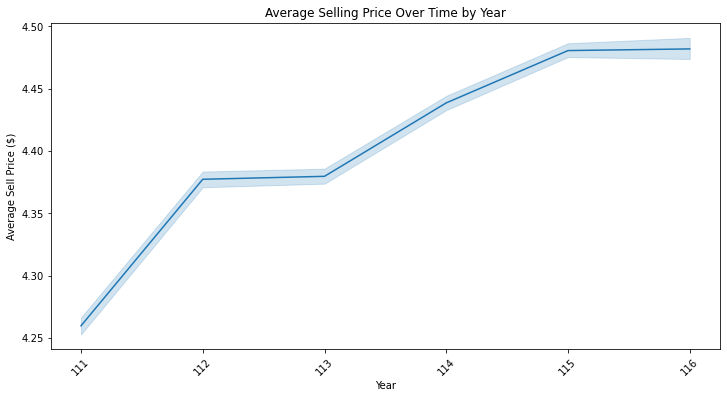

In [25]:
# Feature Selection
price['year'] = price['wm_yr_wk'] // 100
price['week'] = price['wm_yr_wk'] % 100
# Price Trend Analysis: Average selling price over time by year
plt.figure(figsize=(12, 6))
sns.lineplot(data=price, x='year', y='sell_price', estimator='mean')
plt.title('Average Selling Price Over Time by Year')
plt.xlabel('Year')
plt.ylabel('Average Sell Price ($)')
plt.xticks(rotation=45)
plt.show()

In [26]:
# average of price by store

cur.execute("select store_id, avg(sell_price) from sell_price group by store_id")
cur.fetchall()

[('CA_1', 4.414232816724471),
 ('CA_2', 4.445500262778929),
 ('CA_3', 4.388228821732322),
 ('CA_4', 4.42157973564122),
 ('TX_1', 4.374568974378535),
 ('TX_2', 4.366766279615124),
 ('TX_3', 4.387365173798334),
 ('WI_1', 4.457711709646401),
 ('WI_2', 4.4417170300627005),
 ('WI_3', 4.418116619298259)]

- Box plot for each Store with sell price

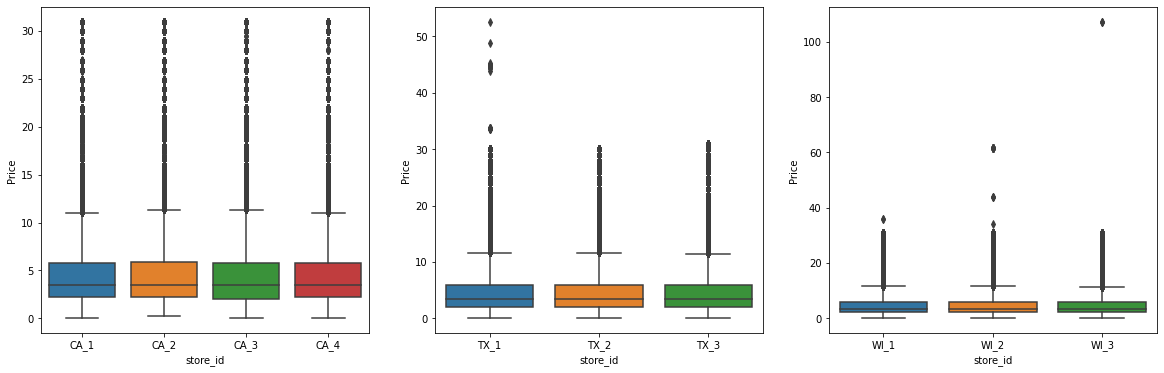

In [27]:
# draw box plot

cur.execute("select * from sell_price where store_id like 'CA%'")

store_df = []
store_df.append(pd.read_sql_query("select * from sell_price where store_id like 'CA%'",conn))
store_df.append(pd.read_sql_query("select * from sell_price where store_id like 'TX%'",conn))
store_df.append(pd.read_sql_query("select * from sell_price where store_id like 'WI%'",conn))

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(len(store_df)):
    sns.boxplot(x="store_id", y="sell_price", data=store_df[i], ax=ax[i])
    ax[i].set_ylabel("Price")

#### 1.2.3 Training Data Analysis

In [28]:
# analyze of train data

print('-'*30, 'Item_Id','-'*30 )
print("Item Id count {}".format(len(train['item_id'].unique())))
print(train['item_id'].unique())

print("-"*30, "dept_id", "-"*30)
print("dept_id values:{}".format(len(train["dept_id"].unique())))
print(train["store_id"].unique())

print("-"*30, "cat_id", "-"*30)
print("cat_id values:{}".format(len(train["cat_id"].unique())))
print(train["cat_id"].unique())

print("-"*30, "state_id", "-"*30)
print("state_id values:{}".format(len(train["state_id"].unique())))
print(train["state_id"].unique())

------------------------------ Item_Id ------------------------------

Item Id count 3049

['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'

 'FOODS_3_826' 'FOODS_3_827']

------------------------------ dept_id ------------------------------

dept_id values:7

['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']

------------------------------ cat_id ------------------------------

cat_id values:3

['HOBBIES' 'HOUSEHOLD' 'FOODS']

------------------------------ state_id ------------------------------

state_id values:3

['CA' 'TX' 'WI']


#### 1.2.4 Time Series Data Analysis by each state and number of selling

In [29]:
# Create dataframe by grouping
state_group = train.groupby("state_id").sum(numeric_only=True).T
state_group = pd.merge(state_group, calendar, left_index=True, right_on="d", how="left").set_index("Date_dt")

- Visualization of sales volume after rolling about 28days

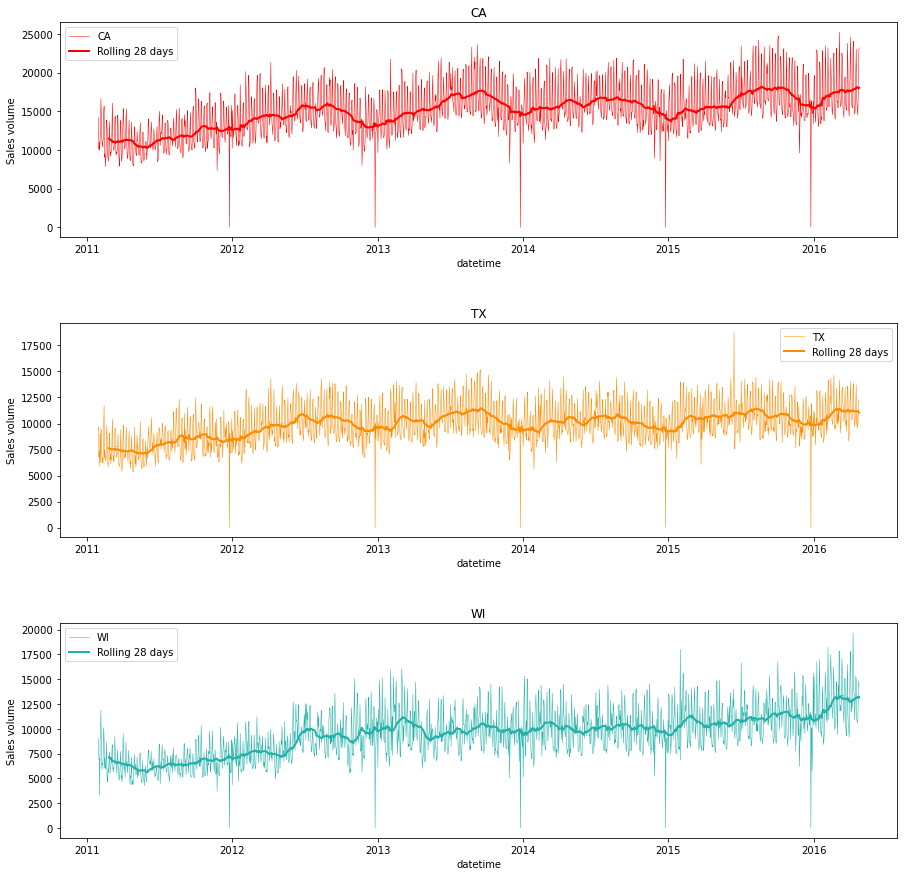

In [30]:
# Visualization
fig, ax = plt.subplots(3,1, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)

color=["red", "darkorange", "lightseagreen"]
state_col = train["state_id"].unique()

for i in range(len(state_col)):
    ax[i].plot(state_group.index, state_group[state_col[i]], color=color[i], linewidth=0.5)
    # Rolling
    ax[i].plot(state_group.index, state_group[state_col[i]].rolling(28).mean(), color=color[i], linewidth=2)
    ax[i].set_xlabel("datetime")
    ax[i].set_ylabel("Sales volume")
    ax[i].legend(["{}".format(state_col[i]), "Rolling 28 days"])
    ax[i].set_title("{}".format(state_col[i]))

- Visualization of sales volume per year

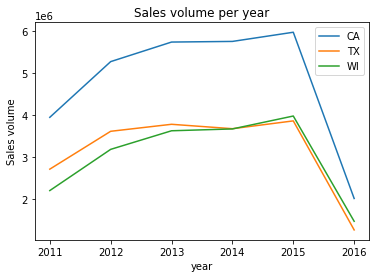

In [31]:
# Sales volume per year
state_group.groupby('year')[['CA', 'TX', 'WI']].sum().plot()
plt.title("Sales volume per year")
plt.ylabel("Sales volume");

#### 1.2.5 Data Components Decomposition and Autocorrelation for each state

In [32]:
# Chrismas Date during these years
#Xmas_date = [pd.datetime(2011,12,25), pd.datetime(2012,12,25), pd.datetime(2013,12,25), pd.datetime(2014,12,25), pd.datetime(2015,12,25)]
Xmas_date = [pd.Timestamp('2011-12-25'), pd.Timestamp('2012-12-25'), pd.Timestamp('2013-12-25'), pd.Timestamp('2014-12-25'), pd.Timestamp('2015-12-25')]

# Drop Xmas
state_group.drop(Xmas_date, inplace=True)

In [33]:
# store new data in SQL
r = cur.execute('''DROP TABLE IF EXISTS state_group''')
conn.commit()
state_group.to_sql(name='state_group', con=conn,if_exists='append',index=False)

In [34]:
# Define time series analysis function
def plot_ts_decomp(base,col, lag, color):
    print("Analised Data:{}".format(col.upper()))
    # Stats model
    data=pd.read_sql_query("SELECT date, "+ col +" from " + base ,conn).set_index('date')
    data.index=pd.to_datetime(data.index)
    res = sm.tsa.seasonal_decompose(data[col], period=lag)
    data["trend"] = res.trend
    data["seaso"] = res.seasonal
    data["resid"] = res.resid

    # Visualization
    fig = plt.figure(figsize=(20,15))
    grid = plt.GridSpec(4,2, hspace=0.4, wspace=0.2)
    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[1,0])
    ax3 = fig.add_subplot(grid[2,0])
    ax4 = fig.add_subplot(grid[3,0])
    ax5 = fig.add_subplot(grid[:-2,1])
    ax6 = fig.add_subplot(grid[2:,1])

    # raw price data
    ax1.plot(data.index, data[col], label="price of {}".format(col), color=color, linewidth=0.5)
    ax1.plot(data.index, data[col].rolling(lag//12).mean(), label="Rolling {}".format(lag//12), color=color, linewidth=2)
    ax1.set_xlabel("date")
    ax1.set_ylabel("price")
    ax1.set_title("raw data")
    ax1.legend()
    # trend
    ax2.plot(data.index, data["trend"], label="trend of {}".format(col), color=color, linewidth=3)
    ax2.set_xlabel("date")
    ax2.set_ylabel("trend")
    ax2.set_title("trend")
    ax2.legend()
    # seasonaly
    ax3.plot(data.index, data["seaso"], label="seasonaly of {}".format(col), color=color, linewidth=0.5)
    ax3.set_xlabel("date")
    ax3.set_ylabel("seasonaly")
    ax3.set_title("seasonaly")
    ax3.legend()
    # residual
    ax4.plot(data.index, data["resid"], label="residual error of {}".format(col), color=color, linewidth=0.5)
    ax4.set_xlabel("date")
    ax4.set_ylabel("residual error")
    ax4.set_title("residual")
    ax4.legend()
    # distribution
    sns.distplot(data[col], ax=ax5)
    ax5.set_xlabel("Price")
    ax5.set_ylabel("Frequency")
    ax5.set_title("distribution")
    # auto correlation
    autocorrelation_plot(data[col], ax=ax6, linewidth=0.5)
    ax6.set_title("autocorrelation")

Analised Data:CA


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


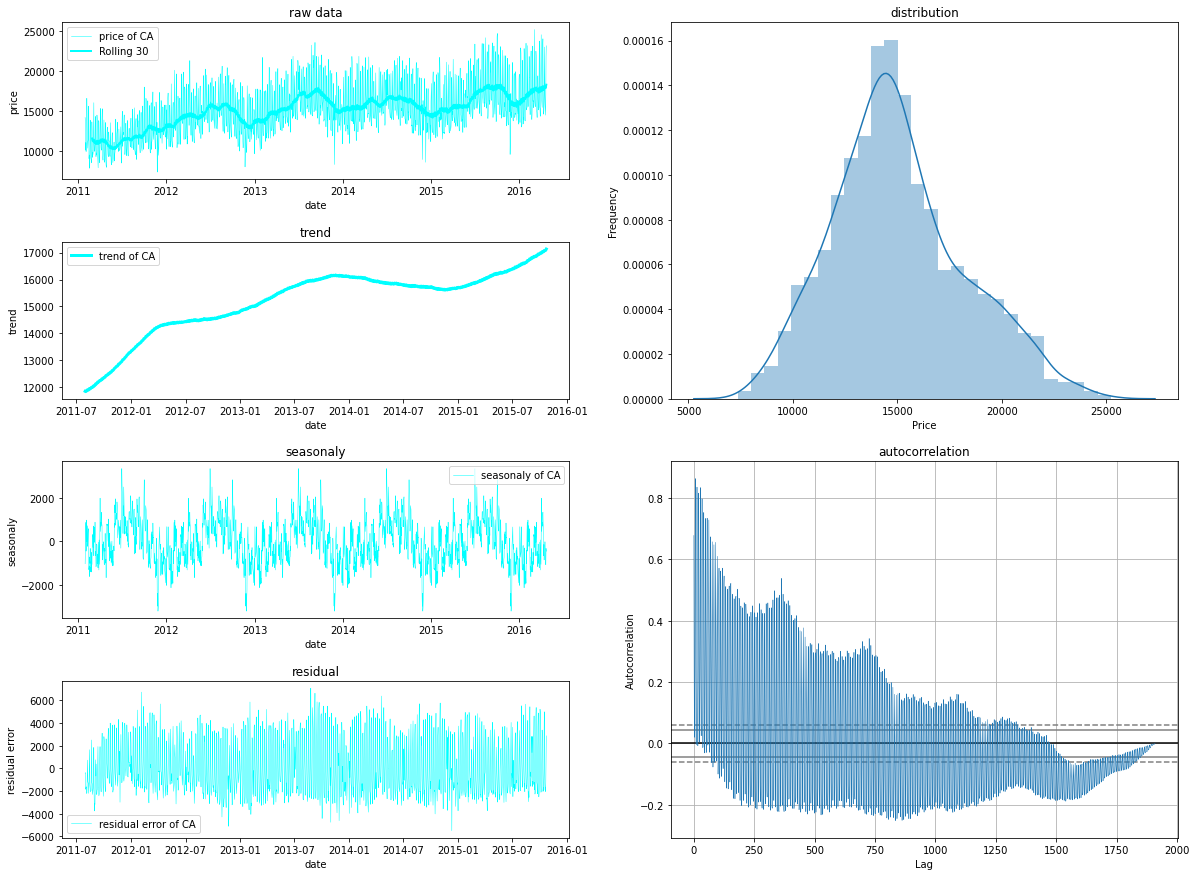

In [35]:
# CA of state
plot_ts_decomp("state_group", "CA", 365, "aqua");

Analised Data:TX


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


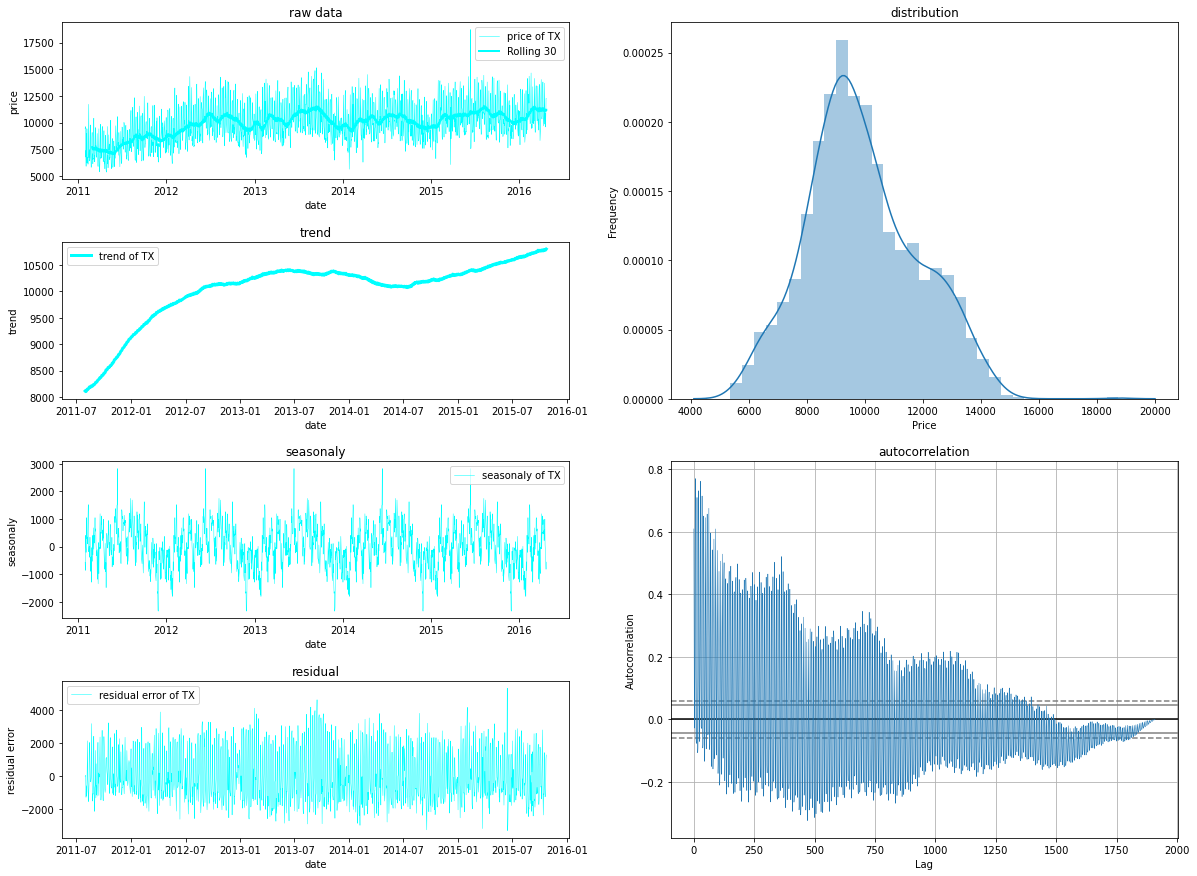

In [36]:
# TX of state
plot_ts_decomp("state_group", "TX", 365, "aqua");

Analised Data:WI


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


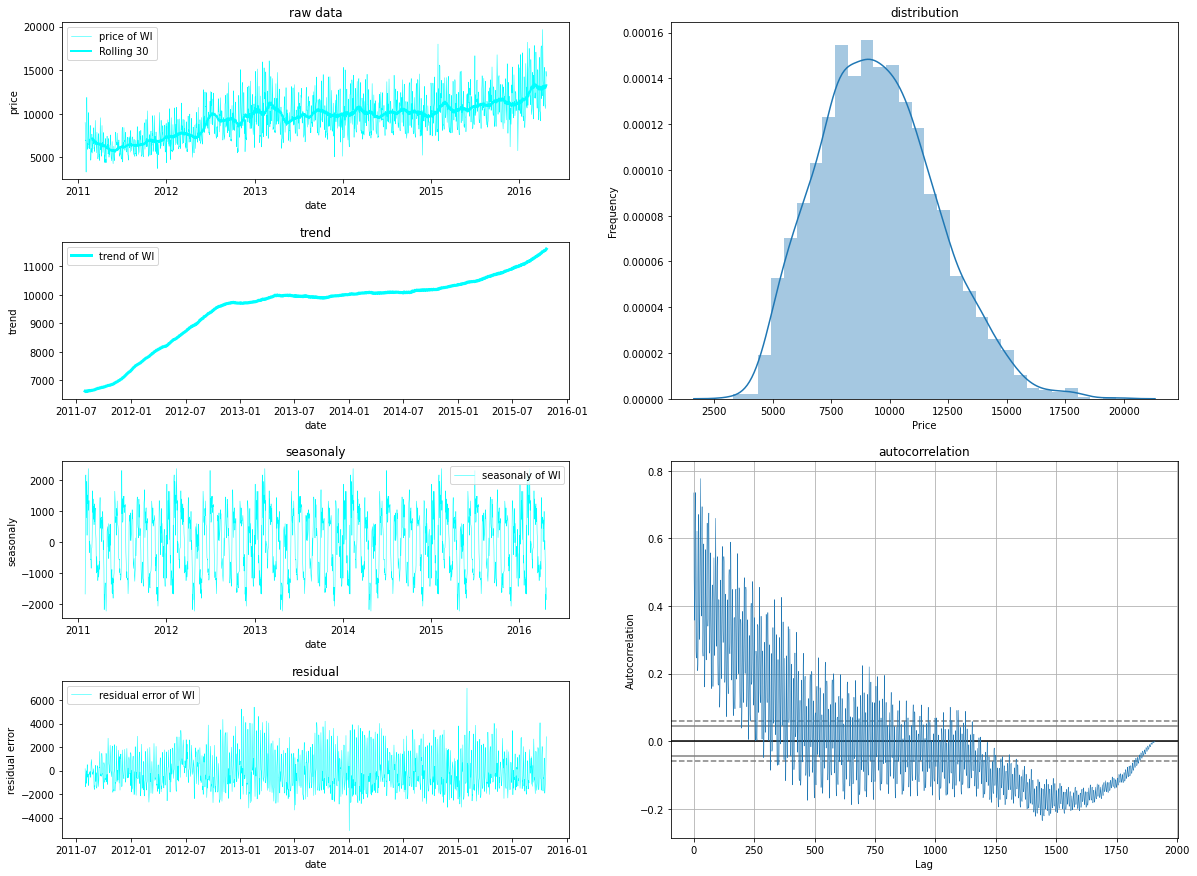

In [37]:
# WI of state
plot_ts_decomp("state_group", "WI", 365, "aqua");

#### 1.2.6 Time Series Data Analysis by each category and number of selling

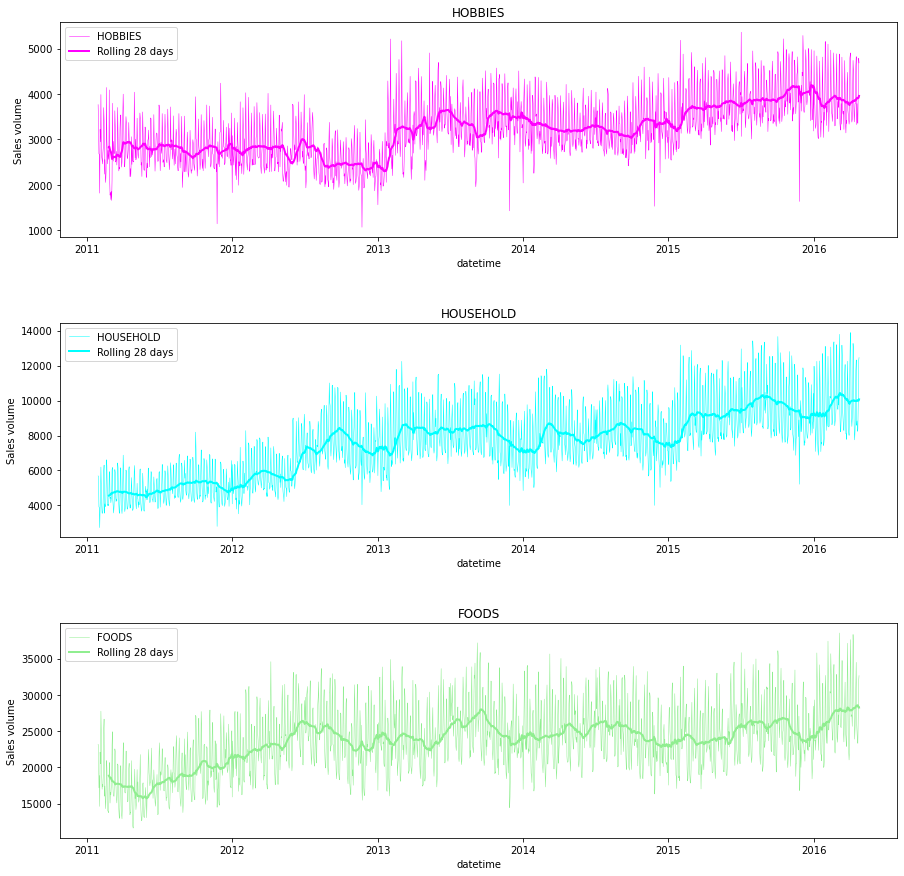

In [38]:
# Create dataframe by grouping
cate_group = train.groupby("cat_id").sum().T
cate_group = pd.merge(cate_group, calendar, left_index=True, right_on="d", how="left").set_index("Date_dt")

# Drop chrismas
cate_group.drop(Xmas_date, inplace=True)

# Visualization
fig, ax = plt.subplots(3,1, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)

color=["magenta", "cyan", "lightgreen"]
cate_col = train["cat_id"].unique()

for i in range(len(cate_col)):
    ax[i].plot(cate_group.index, cate_group[cate_col[i]], color=color[i], linewidth=0.5)
    # Rolling
    ax[i].plot(cate_group.index, cate_group[cate_col[i]].rolling(28).mean(), color=color[i], linewidth=2)
    ax[i].set_xlabel("datetime")
    ax[i].set_ylabel("Sales volume")
    ax[i].legend(["{}".format(cate_col[i]), "Rolling 28 days"])
    ax[i].set_title("{}".format(cate_col[i]))

C:\Users\zhouw\AppData\Local\Temp/ipykernel_10144/1749821103.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

  cate_group.groupby("year")['FOODS', 'HOBBIES', 'HOUSEHOLD'].sum().plot()


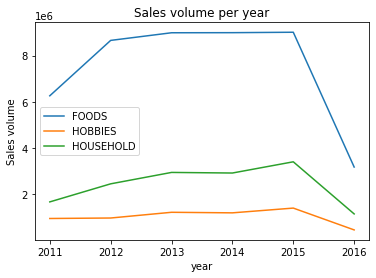

In [39]:
# Sales volume per year
cate_group.groupby("year")['FOODS', 'HOBBIES', 'HOUSEHOLD'].sum().plot()
plt.title("Sales volume per year")
plt.ylabel("Sales volume");

#### 1.2.7 Data Components Decomposition and Autocorrelation for each category

In [40]:
# store new data in SQL
r = cur.execute('''DROP TABLE IF EXISTS cate_group''')
conn.commit()
cate_group.to_sql(name='cate_group', con=conn,if_exists='append',index=False)

Analised Data:HOBBIES


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


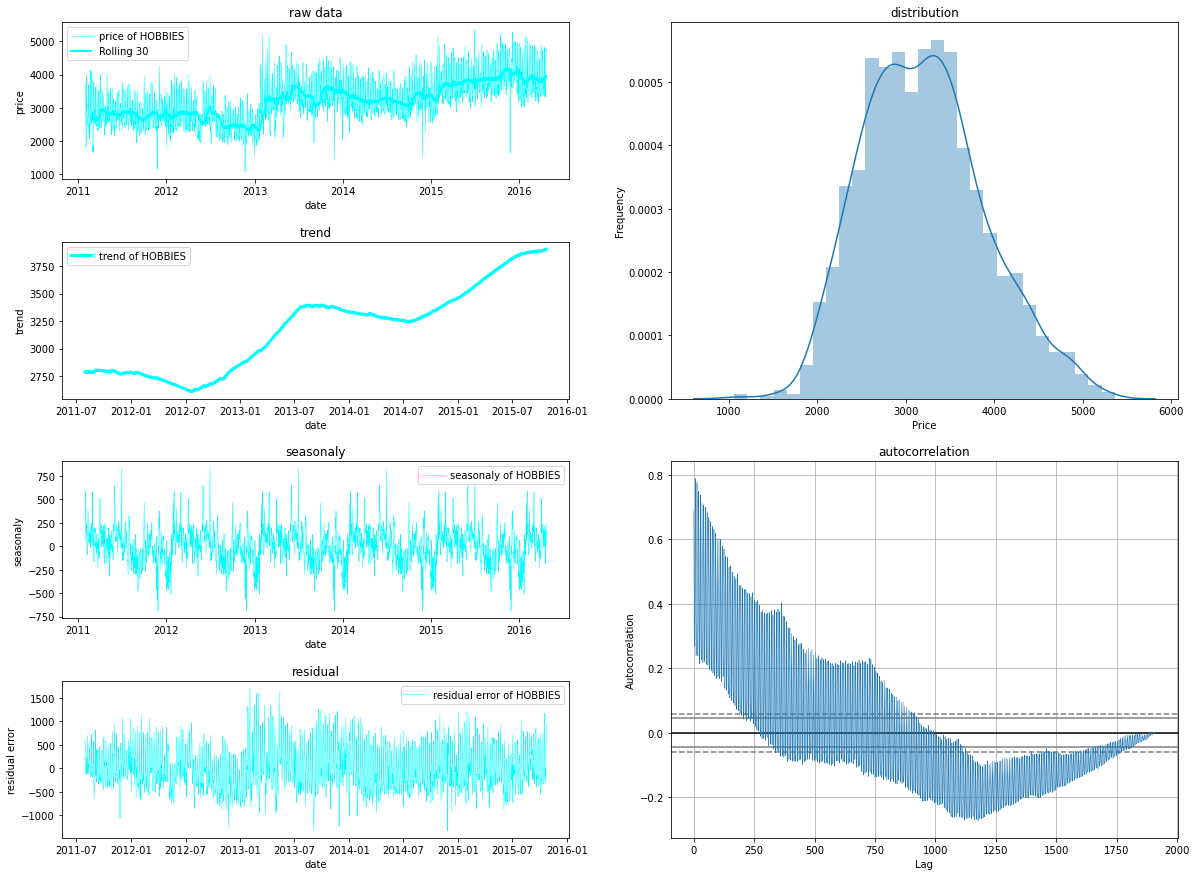

In [41]:
# HOBBIES of cat
plot_ts_decomp("cate_group", "HOBBIES", 365, "aqua");

Analised Data:HOUSEHOLD


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


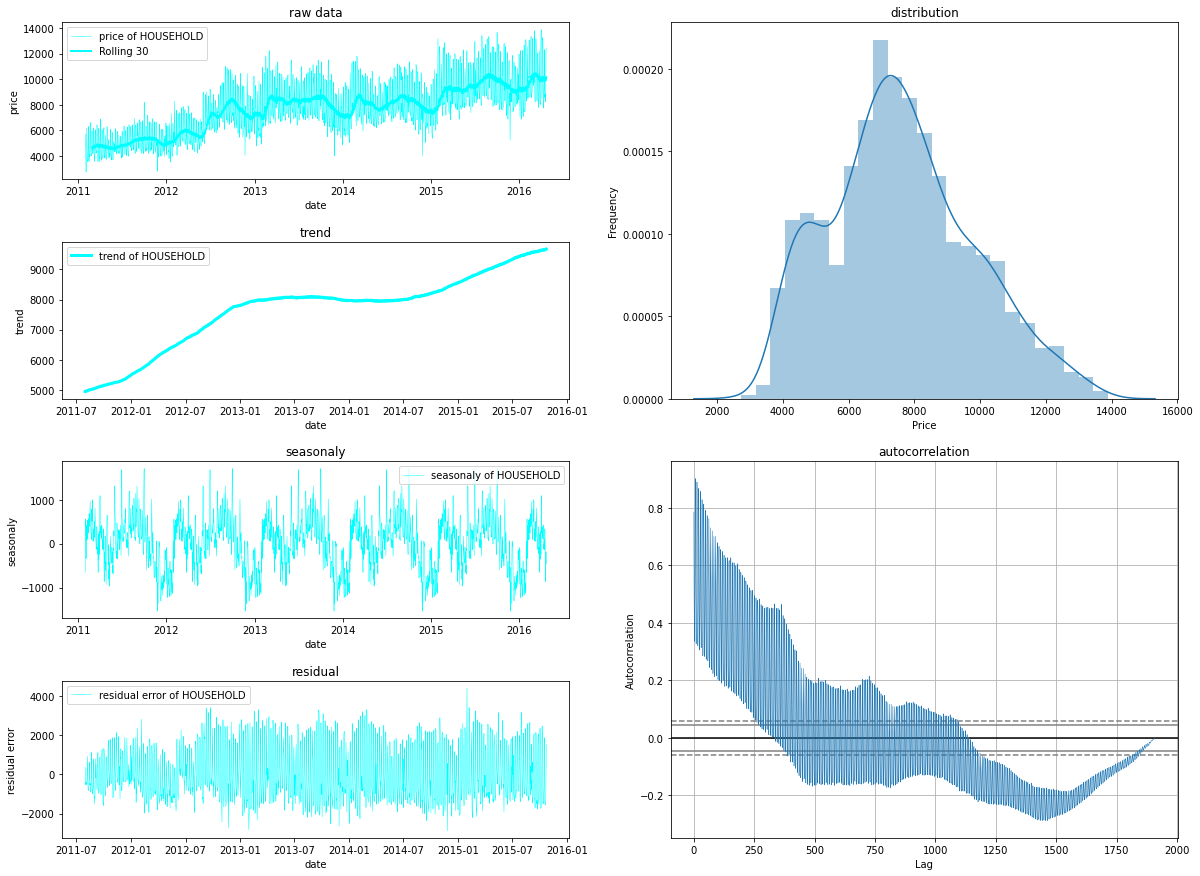

In [42]:
# HOUSEHOLD of cat
plot_ts_decomp("cate_group", "HOUSEHOLD", 365, "aqua");

Analised Data:FOODS


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


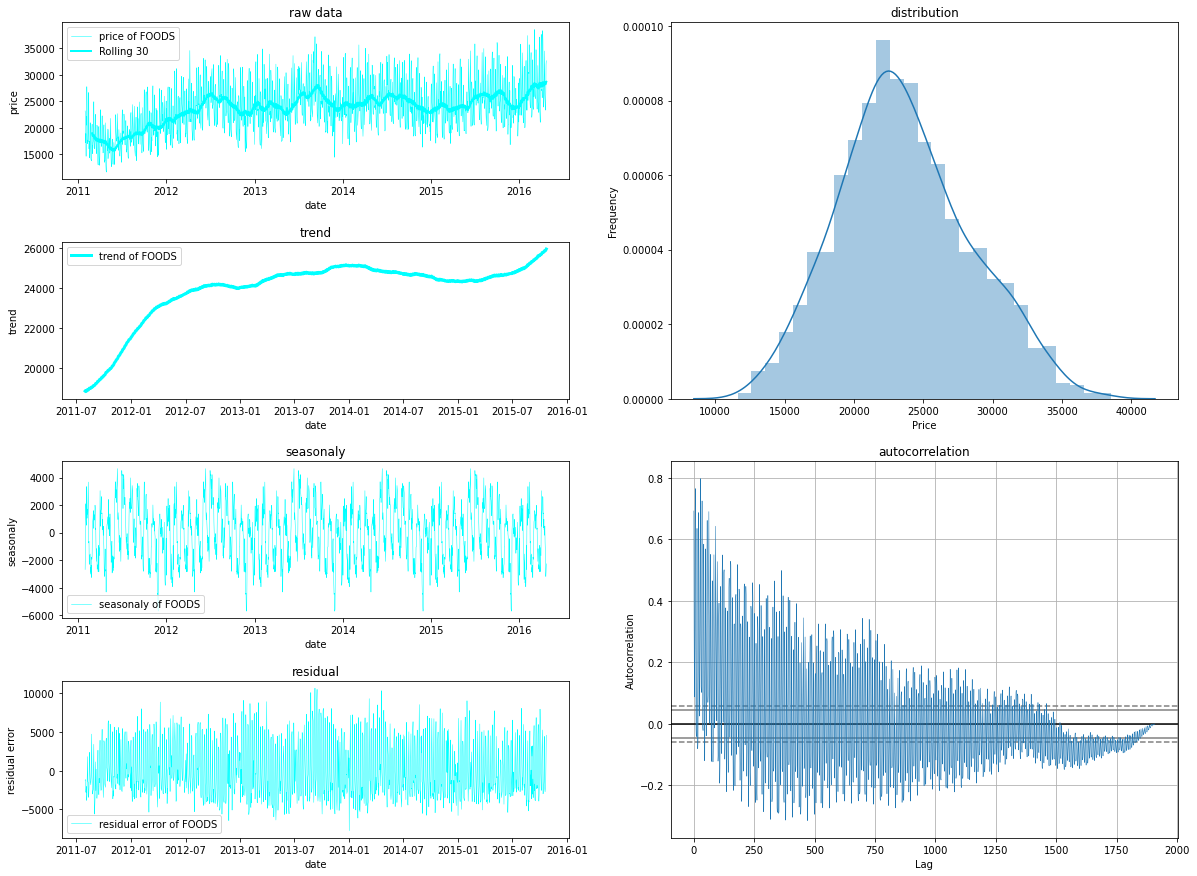

In [43]:
# FOODS of cat
plot_ts_decomp("cate_group", "FOODS", 365, "aqua");

## 2. Prediction sales for Walmart with LGBM Model

In [53]:
#Predict sales for next 2 month.

In [7]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 

from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
from fastprogress import master_bar, progress_bar

import random 
import os
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import time 
from sklearn.metrics import mean_squared_error

device = 'cuda:0'

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [8]:
sell_prices_df = pd.read_csv('../input/walmart-refdata/sell_prices.csv')
calendar_df= pd.read_csv('../input/walmart-refdata/calendar.csv')
sales_train_validation_df = pd.read_csv('../input/walmart-refdata/sales_train_validation.csv')
submission_df = pd.read_csv('../input/walmart-refdata/sample_submission.csv')

In [14]:
#Create date index
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [ ]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,HOBBIES_1_026_CA_1,HOBBIES_1_027_CA_1,HOBBIES_1_028_CA_1,HOBBIES_1_029_CA_1,HOBBIES_1_030_CA_1,HOBBIES_1_031_CA_1,HOBBIES_1_032_CA_1,HOBBIES_1_033_CA_1,HOBBIES_1_034_CA_1,HOBBIES_1_035_CA_1,HOBBIES_1_036_CA_1,HOBBIES_1_037_CA_1,HOBBIES_1_038_CA_1,HOBBIES_1_039_CA_1,HOBBIES_1_040_CA_1,HOBBIES_1_041_CA_1,HOBBIES_1_042_CA_1,HOBBIES_1_043_CA_1,HOBBIES_1_044_CA_1,HOBBIES_1_045_CA_1,HOBBIES_1_046_CA_1,HOBBIES_1_047_CA_1,HOBBIES_1_048_CA_1,HOBBIES_1_049_CA_1,HOBBIES_1_050_CA_1,HOBBIES_1_051_CA_1,HOBBIES_1_052_CA_1,HOBBIES_1_053_CA_1,HOBBIES_1_054_CA_1,HOBBIES_1_055_CA_1,HOBBIES_1_056_CA_1,HOBBIES_1_057_CA_1,HOBBIES_1_058_CA_1,HOBBIES_1_060_CA_1,HOBBIES_1_061_CA_1,HOBBIES_1_062_CA_1,HOBBIES_1_063_CA_1,HOBBIES_1_064_CA_1,HOBBIES_1_065_CA_1,HOBBIES_1_066_CA_1,HOBBIES_1_067_CA_1,HOBBIES_1_068_CA_1,HOBBIES_1_069_CA_1,HOBBIES_1_070_CA_1,HOBBIES_1_072_CA_1,HOBBIES_1_073_CA_1,HOBBIES_1_074_CA_1,HOBBIES_1_075_CA_1,HOBBIES_1_076_CA_1,HOBBIES_1_077_CA_1,HOBBIES_1_078_CA_1,HOBBIES_1_079_CA_1,HOBBIES_1_080_CA_1,HOBBIES_1_081_CA_1,HOBBIES_1_082_CA_1,HOBBIES_1_083_CA_1,HOBBIES_1_084_CA_1,HOBBIES_1_085_CA_1,HOBBIES_1_086_CA_1,HOBBIES_1_087_CA_1,HOBBIES_1_088_CA_1,HOBBIES_1_089_CA_1,HOBBIES_1_090_CA_1,HOBBIES_1_091_CA_1,HOBBIES_1_092_CA_1,HOBBIES_1_093_CA_1,HOBBIES_1_094_CA_1,HOBBIES_1_095_CA_1,HOBBIES_1_097_CA_1,HOBBIES_1_098_CA_1,HOBBIES_1_099_CA_1,HOBBIES_1_100_CA_1,HOBBIES_1_102_CA_1,HOBBIES_1_103_CA_1,HOBBIES_1_104_CA_1,HOBBIES_1_105_CA_1,HOBBIES_1_106_CA_1,HOBBIES_1_107_CA_1,HOBBIES_1_108_CA_1,HOBBIES_1_109_CA_1,HOBBIES_1_110_CA_1,HOBBIES_1_111_CA_1,HOBBIES_1_112_CA_1,HOBBIES_1_113_CA_1,HOBBIES_1_114_CA_1,HOBBIES_1_115_CA_1,HOBBIES_1_116_CA_1,HOBBIES_1_117_CA_1,HOBBIES_1_118_CA_1,HOBBIES_1_119_CA_1,HOBBIES_1_120_CA_1,HOBBIES_1_121_CA_1,HOBBIES_1_122_CA_1,HOBBIES_1_123_CA_1,HOBBIES_1_124_CA_1,HOBBIES_1_125_CA_1,HOBBIES_1_126_CA_1,HOBBIES_1_127_CA_1,HOBBIES_1_128_CA_1,HOBBIES_1_129_CA_1,HOBBIES_1_130_CA_1,HOBBIES_1_131_CA_1,HOBBIES_1_132_CA_1,HOBBIES_1_133_CA_1,HOBBIES_1_134_CA_1,HOBBIES_1_135_CA_1,HOBBIES_1_136_CA_1,HOBBIES_1_137_CA_1,HOBBIES_1_138_CA_1,HOBBIES_1_139_CA_1,HOBBIES_1_140_CA_1,HOBBIES_1_141_CA_1,HOBBIES_1_142_CA_1,HOBBIES_1_143_CA_1,HOBBIES_1_144_CA_1,HOBBIES_1_145_CA_1,HOBBIES_1_146_CA_1,HOBBIES_1_147_CA_1,HOBBIES_1_148_CA_1,HOBBIES_1_149_CA_1,HOBBIES_1_150_CA_1,HOBBIES_1_151_CA_1,HOBBIES_1_152_CA_1,HOBBIES_1_153_CA_1,HOBBIES_1_154_CA_1,HOBBIES_1_155_CA_1,HOBBIES_1_156_CA_1,HOBBIES_1_157_CA_1,HOBBIES_1_158_CA_1,HOBBIES_1_159_CA_1,HOBBIES_1_160_CA_1,HOBBIES_1_161_CA_1,HOBBIES_1_162_CA_1,HOBBIES_1_163_CA_1,HOBBIES_1_164_CA_1,HOBBIES_1_165_CA_1,HOBBIES_1_166_CA_1,HOBBIES_1_167_CA_1,HOBBIES_1_168_CA_1,HOBBIES_1_169_CA_1,HOBBIES_1_170_CA_1,HOBBIES_1_171_CA_1,HOBBIES_1_172_CA_1,HOBBIES_1_173_CA_1,HOBBIES_1_174_CA_1,HOBBIES_1_175_CA_1,HOBBIES_1_176_CA_1,HOBBIES_1_177_CA_1,HOBBIES_1_178_CA_1,HOBBIES_1_179_CA_1,HOBBIES_1_180_CA_1,HOBBIES_1_181_CA_1,HOBBIES_1_183_CA_1,HOBBIES_1_184_CA_1,HOBBIES_1_185_CA_1,HOBBIES_1_186_CA_1,HOBBIES_1_187_CA_1,HOBBIES_1_188_CA_1,HOBBIES_1_189_CA_1,HOBBIES_1_190_CA_1,HOBBIES_1_191_CA_1,HOBBIES_1_192_CA_1,HOBBIES_1_193_CA_1,HOBBIES_1_194_CA_1,HOBBIES_1_195_CA_1,HOBBIES_1_197_CA_1,HOBBIES_1_198_CA_1,HOBBIES_1_199_CA_1,HOBBIES_1_200_CA_1,HOBBIES_1_201_CA_1,HOBBIES_1_202_CA_1,HOBBIES_1_203_CA_1,HOBBIES_1_204_CA_1,HOBBIES_1_205_CA_1,HOBBIES_1_206_CA_1,HOBBIES_1_207_CA_1,HOBBIES_1_208_CA_1,HOBBIES_1_209_CA_1,HOBBIES_1_210_CA_1,HOBBIES_1_211_CA_1,HOBBIES_1_212_CA_1,HOBBIES_1_213_CA_1,HOBBIES_1_214_CA_1,HOBBIES_1_215_CA_1,HOBBIES_1_216_CA_1,HOBBIES_1

### Plot the Time series over time

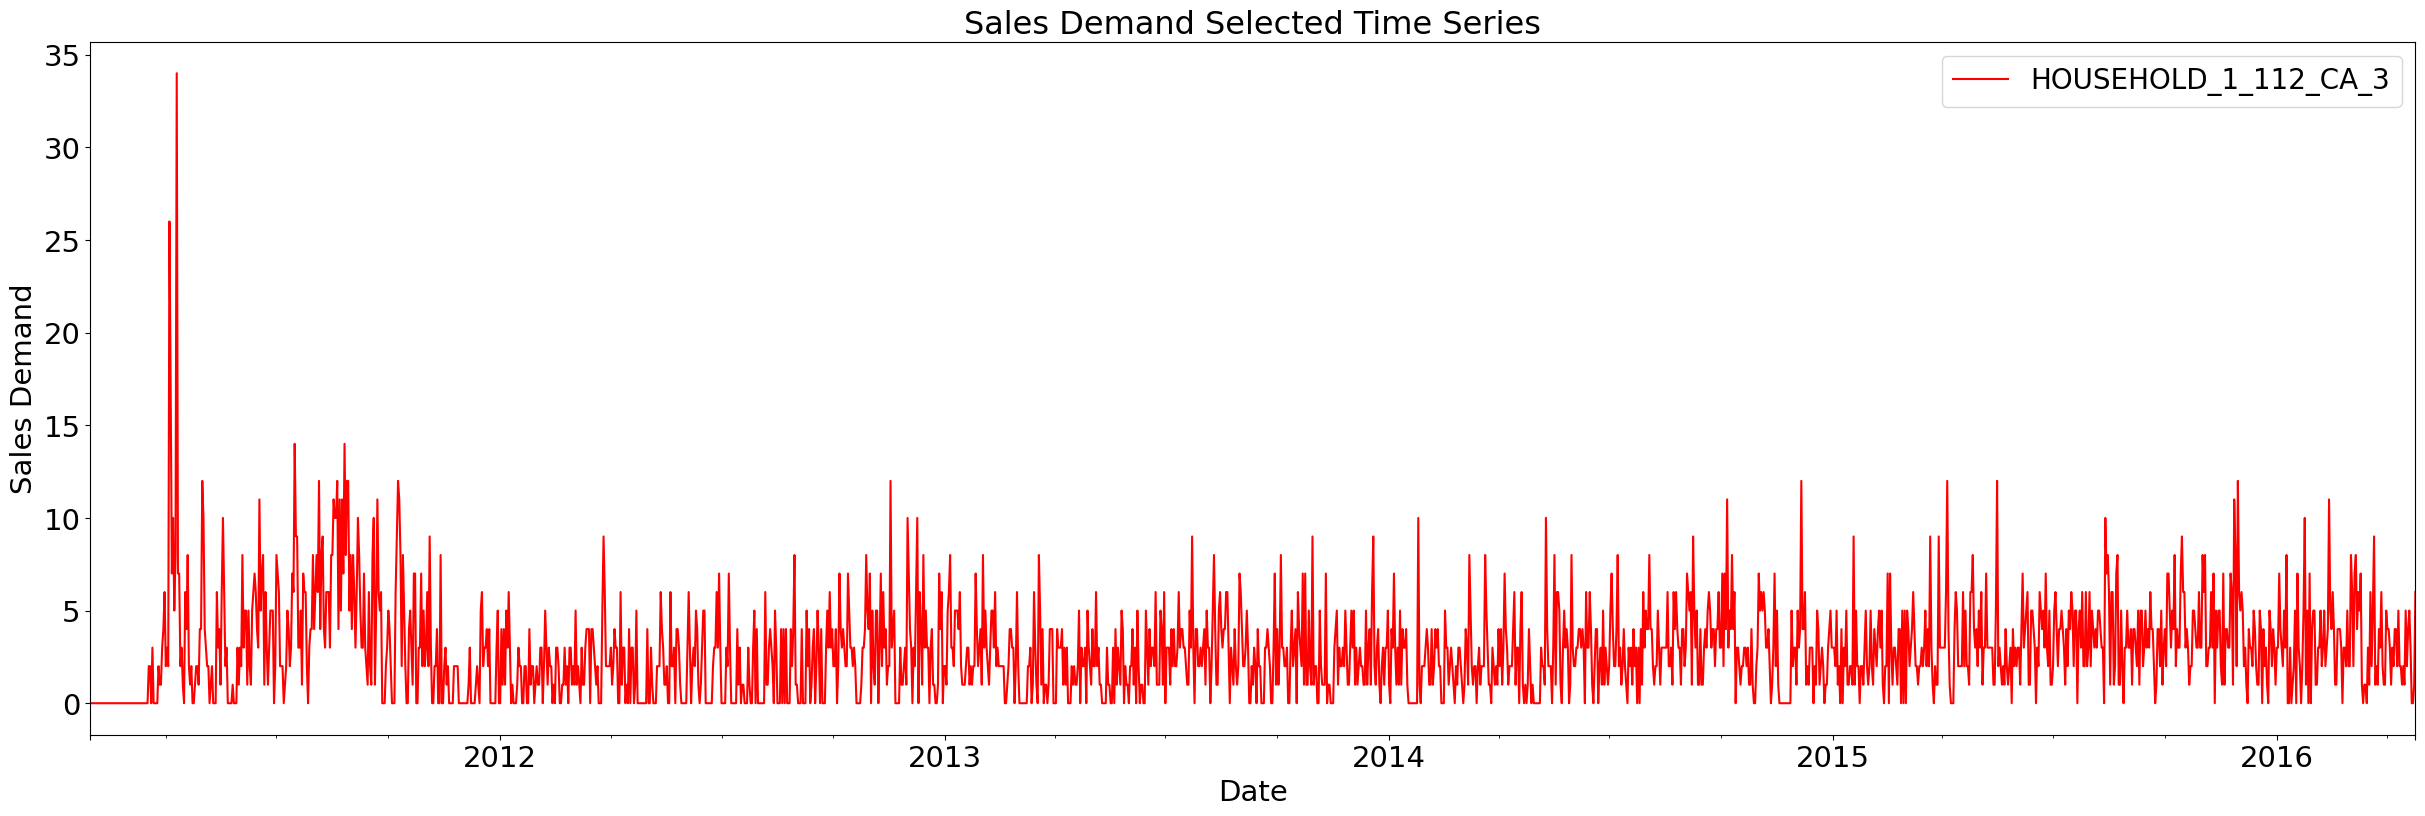

In [73]:
#Select an arbitrary index and plot the time series
index = 6770
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [83]:
# Seed all the index
SEED_num = 1234
def seeding(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seeding(SEED_num)

**Data Normalization**

<Axes: title={'center': ' After '}, ylabel='Frequency'>

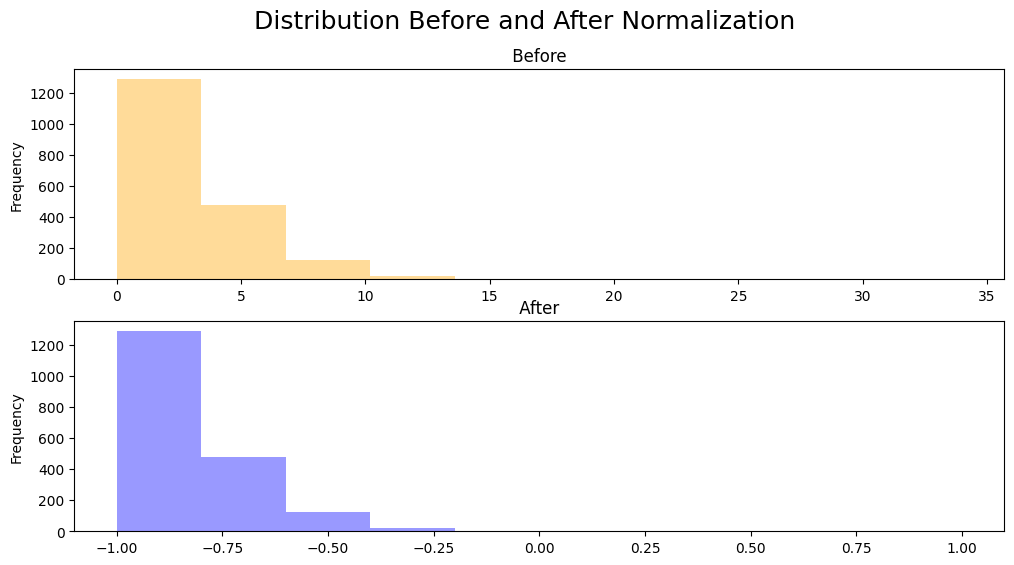

In [84]:
# Using minmaxscaler to normalize the dataset
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

# plots of distribution of data after normalize
fig, axs = plt.subplots(2)
 
fig.suptitle('Distribution Before and After Normalization',fontsize = 18)
pd.DataFrame(data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before ',color ='orange') 
pd.DataFrame(train_data_normalized).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After '\
                                         ,color = 'blue')

In [85]:
# create sliding sequences of 28 days
def sliding_sequences(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

length = 28
x, y = sliding_sequences(train_data_normalized, length)

## Model: Pytorch Tensor Single layer LSTM

In [86]:
# Split the dataset into train and test data
train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

train_X = Variable(torch.Tensor(np.array(x[0:train_size])))
train_Y = Variable(torch.Tensor(np.array(y[0:train_size])))

test_X = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
test_Y = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# Shape of train and test sets
print("train shape is:",train_X.size())
print("train label shape is:",train_Y.size())
print("test shape is:",test_X.size())
print("test label shape is:",test_Y.size())

train shape is: torch.Size([1318, 28, 1])
train label shape is: torch.Size([1318, 1])
test shape is: torch.Size([566, 28, 1])
test label shape is: torch.Size([566, 1])


In [87]:
# LSTM Model
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out
    
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

Epoch: 0, loss: 0.76653 valid loss:  45.17128 
Epoch: 50, loss: 0.15121 valid loss:  0.03475 
Epoch: 100, loss: 0.17580 valid loss:  0.03563 
Epoch: 150, loss: 0.15647 valid loss:  0.03074 
Epoch: 200, loss: 0.16889 valid loss:  0.04200 
Epoch: 250, loss: 0.16485 valid loss:  0.03371 
Epoch: 300, loss: 0.16287 valid loss:  0.04161 
Epoch: 350, loss: 0.15963 valid loss:  0.03809 
Epoch: 400, loss: 0.15491 valid loss:  0.03478 
Epoch: 450, loss: 0.17625 valid loss:  0.03611 


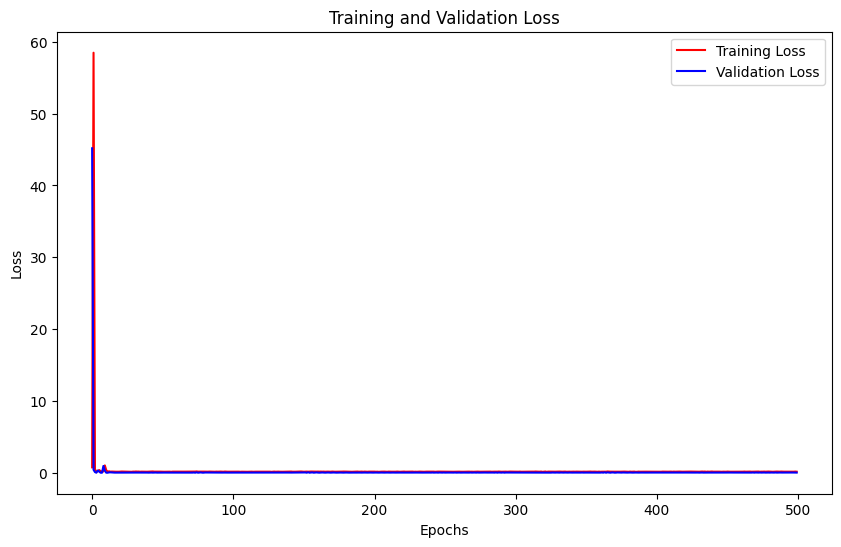

In [88]:
# Model Initialization
num_epochs = 500
learning_rate = 0.01
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

# Set Optimzer and Scheduler
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)

train_loss_set = []
valid_loss_set = []
# Traning model
for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(train_X.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, train_Y.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    # Evaluate testset    
    lstm.eval()
    valid = lstm(test_X.to(device))
    losses = criterion(valid, test_Y.to(device))
    scheduler.step(losses)
    
    train_loss_set.append(loss.cpu().item())
    valid_loss_set.append(losses.cpu().item())
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),losses.cpu().item()))


# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_loss_set, 'r-', label='Training Loss')
plt.plot(range(num_epochs), valid_loss_set, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predict on Dataset

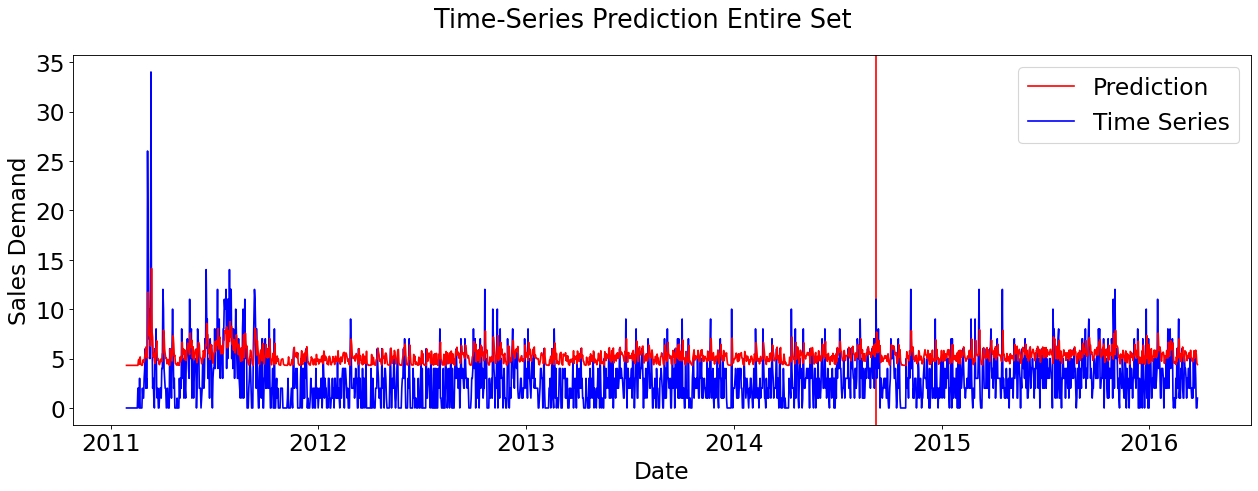

In [93]:
# Predict
lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot(df_labels[0], '-b')
plt.plot(df_predict[0], '-r')
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

## Single Layer LSMT Test RMSE

In [104]:
single_layer_RMSE = np.sqrt(((dataY_plot[-test_X.size()[0]:] - data_predict[-test_X.size()[0]:] ) ** 2).mean())
print(single_layer_RMSE)

1.6035642623901367


## Multi layer LSMT with extra features

In [105]:
df = TS_selected
colnames = df.columns
df = df.rename(columns={colnames[0]:'sales'})
df.tail()

,sales
2016-04-20,3
2016-04-21,0
2016-04-22,0
2016-04-23,1
2016-04-24,6


Shifting: 1
Shifting: 7
Shifting: 14
Shifting: 28
Shifting: 365


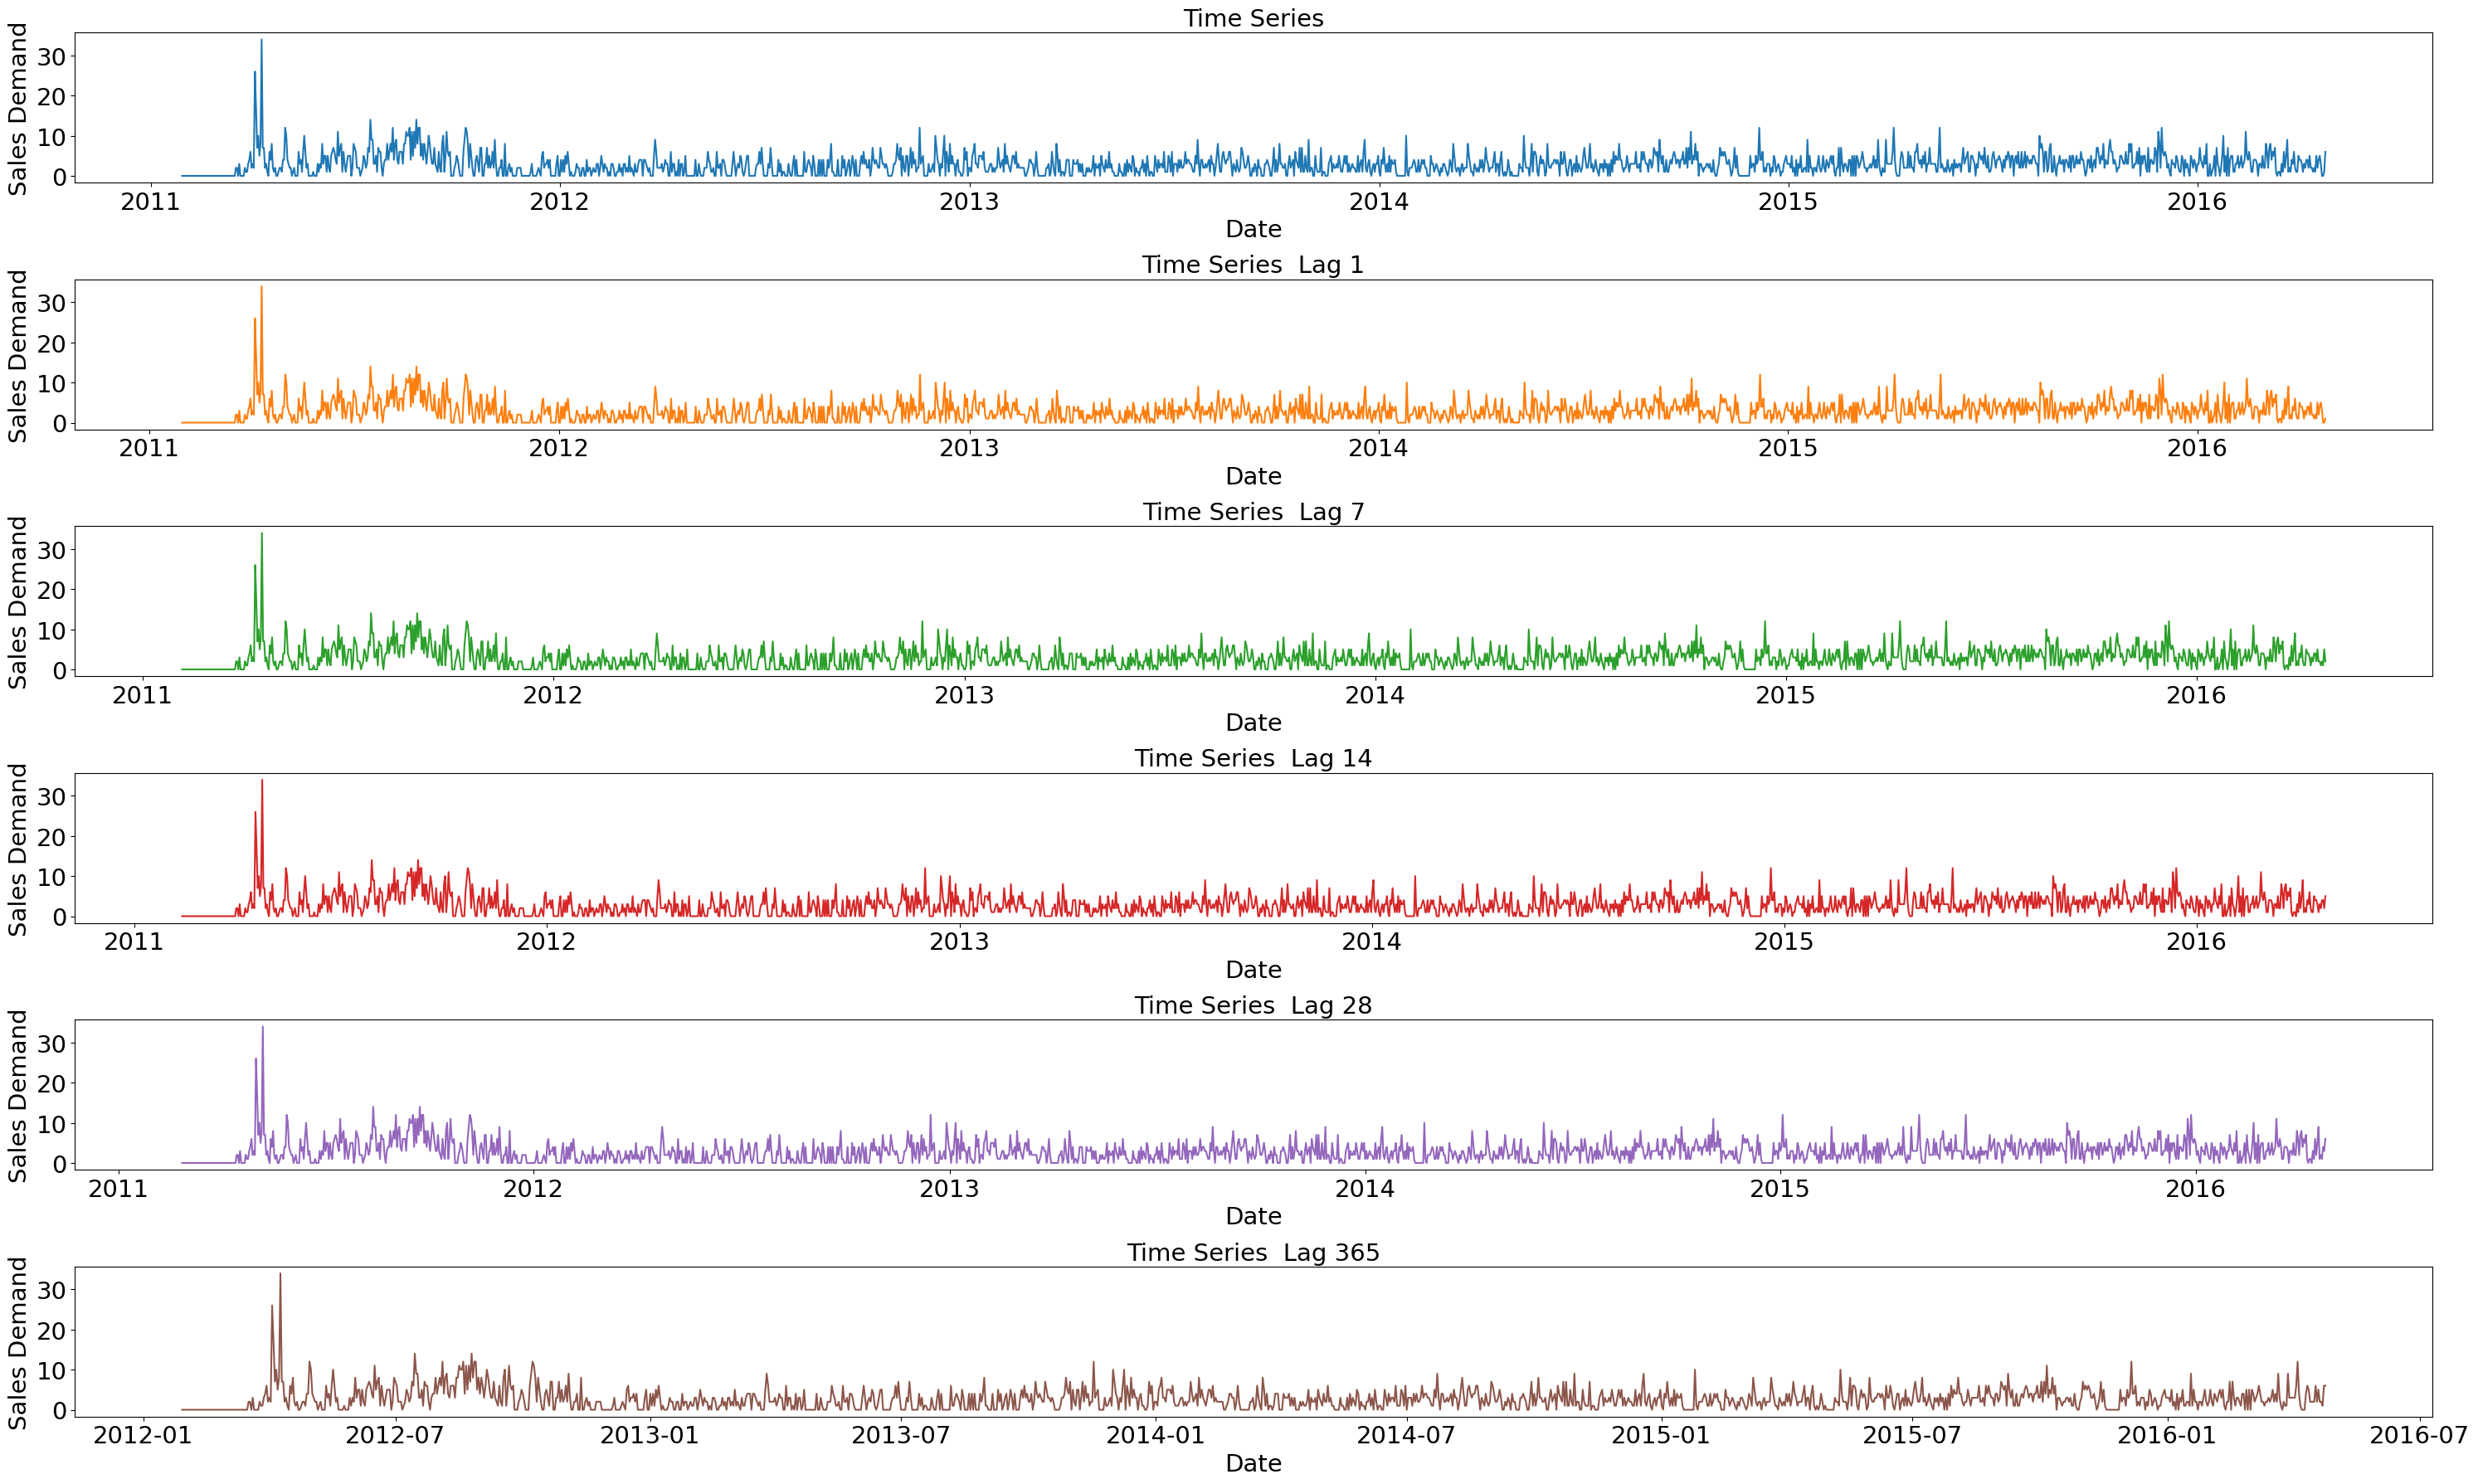

In [ ]:
# Lag Features
start_time = time.time()
for i in (1,7,14,28,365):
    print('Shifting:', i)
    df['lag_'+str(i)] = df['sales'].transform(lambda x: x.shift(i))
    
# Plots of lags
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
df = df.set_index([dates_list])
Product = "Time Series"

fig, axs = plt.subplots(6, 1, figsize=(30, 18))
axs = axs.flatten()
ax_idx = 0

for i in (0,1,7,14,28,365):
    if i == 0:
        ax = df['sales'].plot(fontsize = 21,
                     legend =False,
                     color=next(colors),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product)

        ax_idx += 1
    else : 
        ax = df[f'lag_{i}'].plot(fontsize = 21,
                     legend =False,
                     color=next(colors),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product+f'  Lag {i}')

        ax_idx += 1
    
   
   
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )

plt.tight_layout()
plt.show()

## Rolling Windows

In [125]:
# Use mean and standard deviation
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    df['rolling_mean_' + str(i)] = df['sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    df['rolling_std_' + str(i)]  = df['sales'].transform(lambda x: x.shift(28).rolling(i).std())

# replace NaN with 0
df = df.replace('nan', np.nan).fillna(0)

# Normalization
df_normalized = df.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df) 
y_scaler.fit_transform(df['sales'].values.reshape(-1, 1))
df_normalized.iloc[:,:] =  scaled_data
df_normalized.head()

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 60
Rolling period: 180
Rolling period: 365


,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-01-30,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-01-31,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-02,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Day of week

<Axes: title={'center': ' After Normalization'}, ylabel='Frequency'>

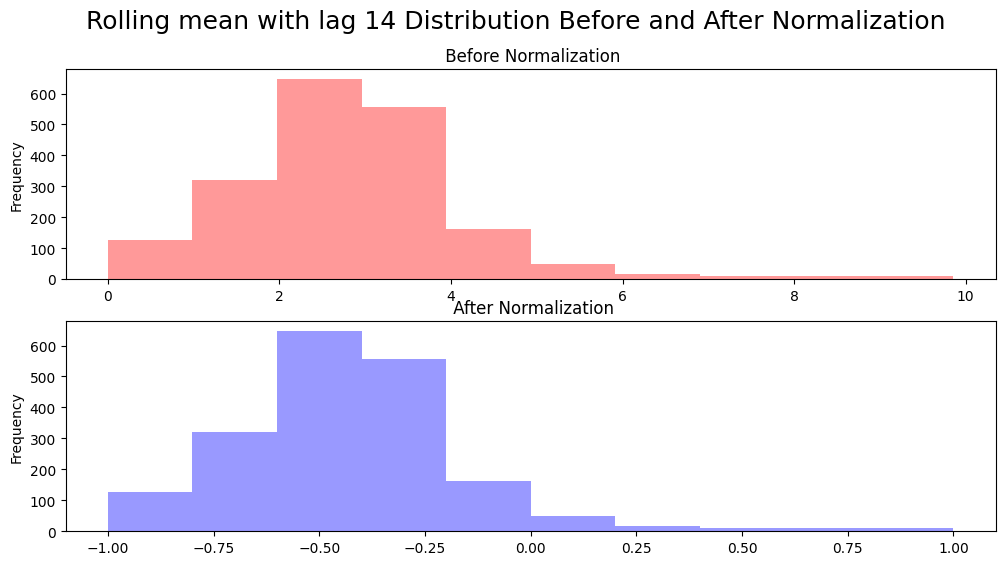

In [126]:
# Merge data from calendar
df_normalized =df_normalized.reset_index()
df_normalized = df_normalized.rename(columns={'index':'date'})
df_normalized['date'] = df_normalized['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
df_normalized =df_normalized.merge(calendar_df[['date','weekday']],on='date')
# df_normalized.head()

# Add Embeded vectors into data fram
df_normalized['wd1'] =0
df_normalized['wd2'] =0
df_normalized['wd3'] =0
df_normalized['wd4'] =0

df_normalized.loc[:,'wd1'][df_normalized['weekday'] =='Sunday'] , df_normalized.loc[:,'wd2'][df_normalized['weekday'] =='Sunday'],\
df_normalized.loc[:,'wd3'][df_normalized['weekday'] =='Sunday'] , df_normalized.loc[:,'wd4'][df_normalized['weekday'] =='Sunday']= 0.4 ,-0.3 ,0.6,0.1

df_normalized.loc[:,'wd1'][df_normalized['weekday'] =='Monday'] , df_normalized.loc[:,'wd2'][df_normalized['weekday'] =='Monday'],\
df_normalized.loc[:,'wd3'][df_normalized['weekday'] =='Monday'] , df_normalized.loc[:,'wd4'][df_normalized['weekday'] =='Monday']= 0.2 ,0.2 ,0.5,-0.3

df_normalized.loc[:,'wd1'][df_normalized['weekday'] =='Tuesday'] ,df_normalized.loc[:,'wd2'][df_normalized['weekday'] =='Tuesday'],\
df_normalized.loc[:,'wd3'][df_normalized['weekday'] =='Tuesday'] , df_normalized.loc[:,'wd4'][df_normalized['weekday'] =='Tuesday']= 0.1,-1.0,1.3,0.9

df_normalized.loc[:,'wd1'][df_normalized['weekday'] =='Wednesday'] , df_normalized.loc[:,'wd2'][df_normalized['weekday'] =='Wednesday'],\
df_normalized.loc[:,'wd3'][df_normalized['weekday'] =='Wednesday'] , df_normalized.loc[:,'wd4'][df_normalized['weekday'] =='Wednesday']= -0.6,0.5,1.2,0.7

df_normalized.loc[:,'wd1'][df_normalized['weekday'] =='Thursday'] , df_normalized.loc[:,'wd2'][df_normalized['weekday'] =='Thursday'],\
df_normalized.loc[:,'wd3'][df_normalized['weekday'] =='Thursday'] , df_normalized.loc[:,'wd4'][df_normalized['weekday'] =='Thursday']= 0.9,0.2,-0.1,0.6

df_normalized.loc[:,'wd1'][df_normalized['weekday'] =='Friday'] , df_normalized.loc[:,'wd2'][df_normalized['weekday'] =='Friday'],\
df_normalized.loc[:,'wd3'][df_normalized['weekday'] =='Friday'] , df_normalized.loc[:,'wd4'][df_normalized['weekday'] =='Friday']= 0.4,1.1,0.3,-1.5


df_normalized.loc[:,'wd1'][df_normalized['weekday'] =='Saturday'] , df_normalized.loc[:,'wd2'][df_normalized['weekday'] =='Saturday'],\
df_normalized.loc[:,'wd3'][df_normalized['weekday'] =='Saturday'] , df_normalized.loc[:,'wd4'][df_normalized['weekday'] =='Saturday']= 0.3,-0.2,0.6,0.0

# Check normalization done
fig, axs = plt.subplots(2)
 
fig.suptitle('Rolling mean with lag 14 Distribution Before and After Normalization',fontsize = 18)
pd.DataFrame(df['rolling_mean_14']).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
pd.DataFrame(df_normalized['rolling_mean_14']).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')

## Multi-Dimensional Sliding Windows

In [130]:
# Generate sliding windows of 28 days with Multiple features
def sliding_windows_mulfeatures(data, seq_length):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        _x = data[i:(i+seq_length),:]
        _y = data[i+seq_length,0] ## column 0 contains the labbel
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y).reshape(-1,1)

data_features = df_normalized[["sales","lag_7","lag_1","lag_28","lag_365","rolling_mean_7",\
"rolling_std_7","rolling_mean_14","rolling_std_14","rolling_mean_28","rolling_std_28","rolling_mean_60","rolling_std_60",'lag_28','wd1','wd2','wd3','wd4']].to_numpy() 

# data_features.shape
# Create sliding window
x , y = sliding_windows_mulfeatures(data_features,seq_length=28)
print("X shape: ",x.shape)
print("y shape: ",y.shape)

X shape:  (1884, 28, 18)
y shape:  (1884, 1)


## Model Enhance: Multiple output layers

In [171]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [155]:
class LSTMv2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTMv2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTMv2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.2)
       
        
        
        self.fc1 = nn.Linear(hidden_size,256)
        self.bn1 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 128)
            
        self.bn2 = nn.BatchNorm1d(128,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp2 = nn.Dropout(0.2)
        self.fc3= nn.Linear(128, 1)
        self.relu = nn.ReLU()
       
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTMv2(x, (h_1, c_1))
     
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        
        x0 = self.fc1(final_state)
        x0 = self.bn1(x0)
        x0 = self.dp1(x0)
        x0 = self.relu(x0)
        
        x0 = self.fc2(x0)
        x0 = self.bn2(x0)
        x0 = self.dp2(x0)
        
        x0 = self.relu(x0)
        
        out = self.fc3(x0)

        return out

**Model version 2 traning**

In [186]:
# Training hyperparameters
num_epochs = 500
learning_rate = 0.003
input_size = 18
hidden_size = 512
num_layers = 4
num_classes = 1

best_val_loss = 100

lstm = LSTMv2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.07, 0.07)

lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    scheduler.step(loss)
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    val_loss = criterion(valid, testY.to(device))
    scheduler.step(val_loss)
    
    if val_loss.cpu().item() < best_val_loss:
         torch.save(lstm.state_dict(), 'best_model.pt')
         print("best on epoch:",epoch,"val loss is:",val_loss.cpu().item())
         best_val_loss = val_loss.cpu().item()
            
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),val_loss.cpu().item()))

best on epoch: 0 val loss is: 0.5627813935279846
Epoch: 0, loss: 0.64302 valid loss:  0.56278 
best on epoch: 1 val loss is: 0.537861168384552
best on epoch: 2 val loss is: 0.5119549632072449
best on epoch: 3 val loss is: 0.4916955828666687
best on epoch: 4 val loss is: 0.46697741746902466
best on epoch: 5 val loss is: 0.4439992904663086
best on epoch: 6 val loss is: 0.4182785749435425
best on epoch: 7 val loss is: 0.39767542481422424
best on epoch: 8 val loss is: 0.3627561032772064
best on epoch: 9 val loss is: 0.3459969162940979
best on epoch: 10 val loss is: 0.30227988958358765
best on epoch: 11 val loss is: 0.28089550137519836
best on epoch: 12 val loss is: 0.26345425844192505
best on epoch: 13 val loss is: 0.25627127289772034
best on epoch: 14 val loss is: 0.23093943297863007
best on epoch: 15 val loss is: 0.18390536308288574
best on epoch: 17 val loss is: 0.1385066956281662
best on epoch: 18 val loss is: 0.11142171174287796
best on epoch: 19 val loss is: 0.08228500932455063
best 

## 3. Results

### Final Prediction on dataset

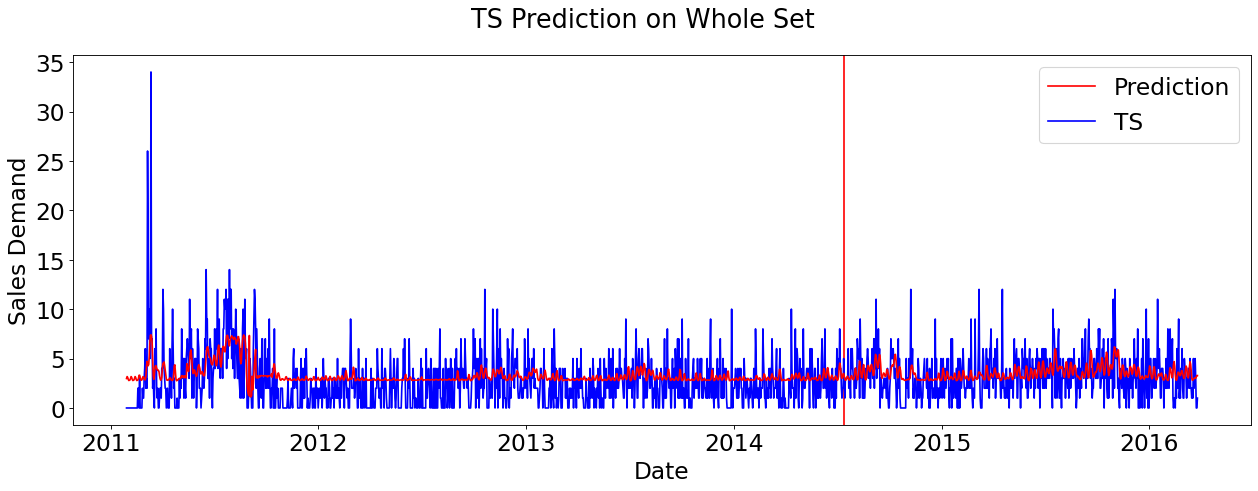

In [187]:
lstm.load_state_dict(torch.load('best_model.pt'))

lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()


## Inverse Normalization
data_predict = y_scaler.inverse_transform(data_predict)
dataY_plot = y_scaler.inverse_transform(dataY_plot.reshape(-1, 1))

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot(df_labels[0], '-b')
plt.plot(df_predict[0], '-r')
plt.legend(['Prediction','TS'],fontsize = 21)
plt.suptitle('TS Prediction on Whole Set',fontsize = 23)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

### RMSE - LSTMv2 test

In [189]:
final_rmse = np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())
print(final_rmse)

0.9907637119293213


# 4. Next